In [1]:
# Import semua library yang dibutuhkan
import os
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd
from PIL import Image

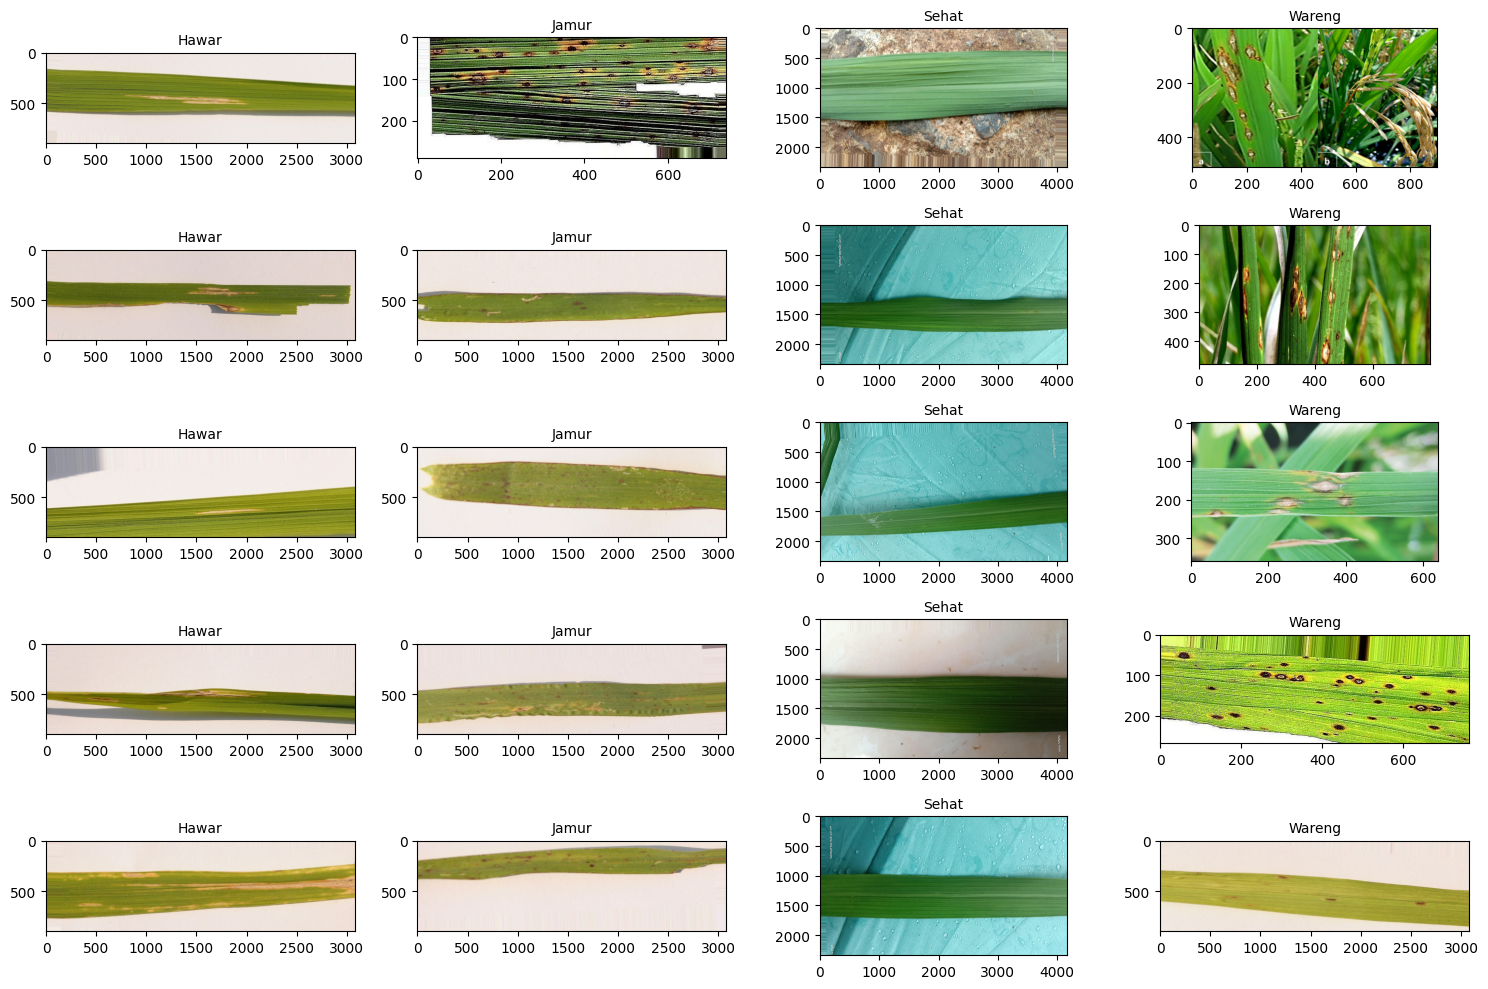

In [2]:
# Path dataset (UBAH SESUAI DENGAN LOKASI DATASET ANDA)
dataset_path = r'C:\Users\LOQ\Downloads\Machine Learning\padi\penyakit_padi'

# Membuat DataFrame dengan label kategori dan path gambar
data = []
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        for img_file in os.listdir(category_path):
            img_path = os.path.join(category_path, img_file)
            if img_file.lower().endswith(('png', 'jpg', 'jpeg')):
                data.append({'Label': category, 'Filepath': img_path})

df = pd.DataFrame(data)

# Menampilkan 5 gambar dari setiap kategori
samples_per_category = 5
categories = df['Label'].unique()
fig, axes = plt.subplots(samples_per_category, len(categories), figsize=(15, 10))

for col, label in enumerate(categories):
    sample_imgs = df[df['Label'] == label]['Filepath'].iloc[:samples_per_category]
    for row, img_path in enumerate(sample_imgs):
        try:
            img = Image.open(img_path)
            axes[row, col].imshow(img)
            axes[row, col].set_title(f"{label}", fontsize=10)
            axes[row, col].axis('on')
        except Exception as e:
            print(f"Error loading image for label '{label}': {e}")

plt.tight_layout()
plt.show()

In [3]:
# Menampilkan jumlah total data per kategori
category_counts = df['Label'].value_counts()

# Menampilkan jumlah total dataset (kategori dan gambar)
total_dataset = category_counts.sum()
print(f"Total dataset: {total_dataset} gambar")

# Menampilkan jumlah gambar per kategori
print("Jumlah gambar per kategori:")
print(category_counts)

Total dataset: 3058 gambar
Jumlah gambar per kategori:
Label
Wareng    773
Jamur     768
Hawar     759
Sehat     758
Name: count, dtype: int64


In [37]:
# Ukuran gambar untuk MobileNetV2
image_size = (224, 224)

# Load dataset gambar
images = []
labels = []

for label in os.listdir(dataset_path):
    label_folder = os.path.join(dataset_path, label)
    
    if os.path.isdir(label_folder):
        for image_name in os.listdir(label_folder):
            image_path = os.path.join(label_folder, image_name)
            if image_path.endswith(('.jpeg', '.jpg', '.png')):
                img = load_img(image_path, target_size=image_size)
                img_array = img_to_array(img) / 255.0  # Normalisasi

                images.append(img_array)
                labels.append(label)

# Simpan dataset dalam format pickle
images = np.array(images)
labels = np.array(labels)
with open('dataset_padi.pkl', 'wb') as f:
    pickle.dump((images, labels), f)

# Tampilkan pesan berhasil disimpan
print("Dataset berhasil disimpan dalam 'dataset_padi.pkl'")

In [38]:
# Load dataset dari pickle
with open('dataset_padi.pkl', 'rb') as f:
    images, labels = pickle.load(f)

# Encode label
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)
labels = to_categorical(labels, num_classes=4)

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [39]:
# Load MobileNetV2
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freezing model

# Membuat model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 kelas penyakit padi
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Menampilkan struktur model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [40]:
# Training model
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    batch_size=16  # Gunakan batch kecil jika ada masalah memori
)

# Simpan model
model.save('model_padi.h5')
print("Model telah disimpan sebagai 'model_padi.h5'")

Epoch 1/10
153/153 [==============================] - 7s 36ms/step - loss: 0.3249 - accuracy: 0.8913 - val_loss: 0.1429 - val_accuracy: 0.9755
Epoch 2/10
153/153 [==============================] - 5s 31ms/step - loss: 0.0960 - accuracy: 0.9804 - val_loss: 0.1002 - val_accuracy: 0.9820
Epoch 3/10
153/153 [==============================] - 5s 31ms/step - loss: 0.0560 - accuracy: 0.9914 - val_loss: 0.0572 - val_accuracy: 0.9951
Epoch 4/10
153/153 [==============================] - 5s 31ms/step - loss: 0.0374 - accuracy: 0.9967 - val_loss: 0.0468 - val_accuracy: 0.9918
Epoch 5/10
153/153 [==============================] - 5s 31ms/step - loss: 0.0271 - accuracy: 0.9984 - val_loss: 0.0396 - val_accuracy: 0.9951
Epoch 6/10
153/153 [==============================] - 5s 31ms/step - loss: 0.0206 - accuracy: 1.0000 - val_loss: 0.0321 - val_accuracy: 0.9935
Epoch 7/10
153/153 [==============================] - 5s 31ms/step - loss: 0.0166 - accuracy: 1.0000 - val_loss: 0.0272 - val_accuracy: 0.9951

20/20 [==============================] - 1s 44ms/step - loss: 0.0200 - accuracy: 0.9967
Evaluation Loss: 0.019975557923316956
Evaluation Accuracy: 0.9967319965362549


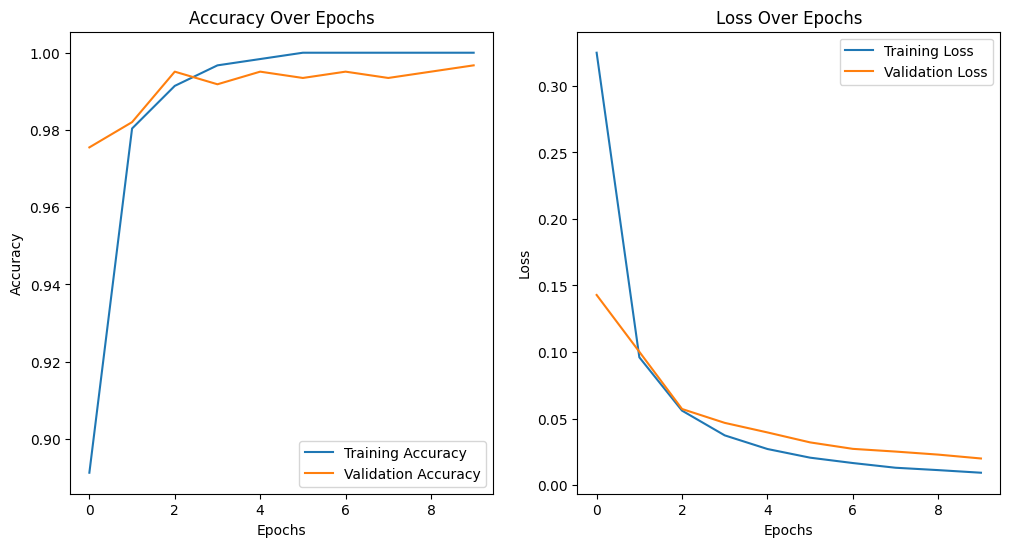

In [41]:
# Model evaluation
eval_loss, eval_acc = model.evaluate(X_val, y_val)
print(f"Evaluation Loss: {eval_loss}")
print(f"Evaluation Accuracy: {eval_acc}")

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 6))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

20/20 [==============================] - 1s 44ms/step


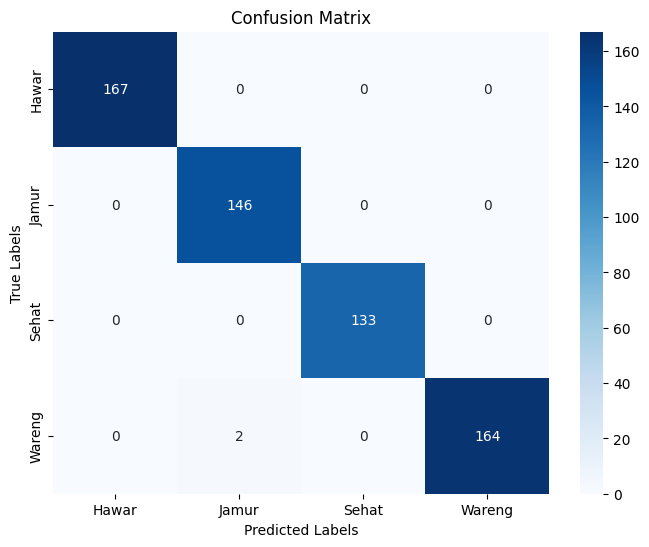

Classification Report:
              precision    recall  f1-score   support

       Hawar       1.00      1.00      1.00       167
       Jamur       0.99      1.00      0.99       146
       Sehat       1.00      1.00      1.00       133
      Wareng       1.00      0.99      0.99       166

    accuracy                           1.00       612
   macro avg       1.00      1.00      1.00       612
weighted avg       1.00      1.00      1.00       612


Kesimpulan Akhir:
Rata-rata Precision: 0.9966
Rata-rata Recall: 0.9970
Rata-rata F1-Score: 0.9968


In [42]:
# Confusion Matrix
y_pred = model.predict(X_val)
y_pred_class = np.argmax(y_pred, axis=1)  # Get the class predictions

y_true_class = np.argmax(y_val, axis=1)  # Get the true labels
cm = confusion_matrix(y_true_class, y_pred_class)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
report = classification_report(y_true_class, y_pred_class, target_names=encoder.classes_)
print("Classification Report:")
print(report)

# Kesimpulan Akhir - Rata-rata Precision, Recall, dan F1-Score
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and f1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_true_class, y_pred_class, average=None)

# Calculate average precision, recall, and f1-score (macro average)
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1 = np.mean(f1)

# Print the averages
print("\nKesimpulan Akhir:")
print(f"Rata-rata Precision: {avg_precision:.4f}")
print(f"Rata-rata Recall: {avg_recall:.4f}")
print(f"Rata-rata F1-Score: {avg_f1:.4f}")

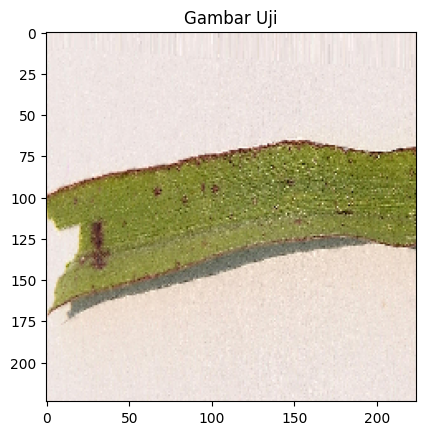

1/1 [==============================] - 1s 552ms/step

📌 Prediction Probabilities:
Hawar: 0.06%
Jamur: 99.92%
Sehat: 0.00%
Wareng: 0.02%

✅ Predicted Class: **Jamur**


In [3]:
# Memuat kembali model yang telah dilatih
model = tf.keras.models.load_model('model_padi.h5')

# Menentukan label kelas
class_labels = ['Hawar', 'Jamur', 'Sehat', 'Wareng']

# Path gambar uji (UBAH SESUAI LOKASI FILE)
image_path = r"C:\Users\LOQ\Downloads\Machine Learning\padi\penyakit_padi\Jamur\aug_0_975.jpeg"

# Load dan menampilkan gambar uji
img_size = (224, 224)
img = load_img(image_path, target_size=img_size)
plt.imshow(img)
plt.title("Gambar Uji")
plt.axis('on')
plt.show()

# Preprocessing gambar
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Prediksi
prediction = model.predict(img_array)[0]
predicted_class = class_labels[np.argmax(prediction)]

# Menampilkan hasil prediksi
print("\n📌 Prediction Probabilities:")
for label, prob in zip(class_labels, prediction):
    print(f"{label}: {prob * 100:.2f}%")

print(f"\n✅ Predicted Class: **{predicted_class}**")